In [ ]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc

# Graphic Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print(">>> The libraries are successfully loaded.")

>>> The libraries are successfully loaded.


In [ ]:
# We import our dataset. If an error occurs, an alert is displayed.
try:
    df = pd.read_csv('data.csv', sep=';')
    print(f">>> Dataset is uploaded. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'data.csv' can not found. Please try again!")

>>> Dataset is uploaded. Shape: (4424, 37)


In [ ]:
df.shape

(4424, 37)

In [ ]:
df.head(20)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
5,2,39,1,9991,0,19,133.1,1,37,37,...,0,5,17,5,11.500000,5,16.2,0.3,-0.92,Graduate
6,1,1,1,9500,1,1,142.0,1,19,38,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
7,1,18,4,9254,1,1,119.0,1,37,37,...,0,5,5,0,0.000000,0,15.5,2.8,-4.06,Dropout
8,1,1,3,9238,1,1,137.0,62,1,1,...,0,6,7,6,14.142857,0,16.2,0.3,-0.92,Graduate
9,1,1,1,9238,1,1,138.0,1,1,19,...,0,6,14,2,13.500000,0,8.9,1.4,3.51,Dropout


In [ ]:
# Overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [ ]:
# checking total null values(missing values)
df.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

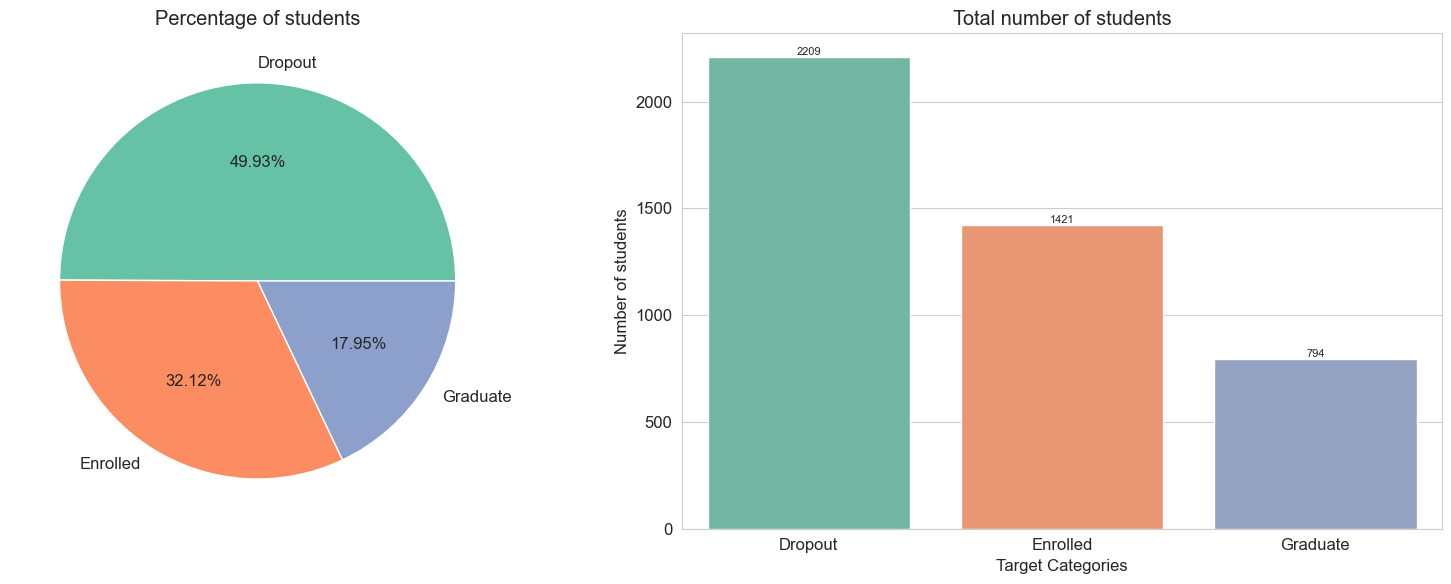

In [ ]:
data_pie = df['Target'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PIE CHART
ax1.pie(
    data_pie,
    autopct="%.2f%%",
    labels=["Dropout", "Enrolled", "Graduate"],
    colors=sns.color_palette('Set2') 
)
ax1.set_title('Percentage of students')

# BAR CHART
sns.barplot(
    x=["Dropout", "Enrolled", "Graduate"],
    y=data_pie.values,
    hue=["Dropout", "Enrolled", "Graduate"],  
    palette="Set2",
    dodge=False,  
    ax=ax2,
    legend=False  
)


ax2.set_xlabel('Target Categories')
ax2.set_ylabel('Number of students')
ax2.set_title('Total number of students')

# LABELS
for i, value in enumerate(data_pie.values):
    ax2.text(i, value, value, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# We derive additional features to increase the model’s predictive capabilities.

print(">>> Feature Engineering Process")

# A) Rate of Passing Lesson (Approved / Enrolled)
df['App_Rate_1st'] = df['Curricular units 1st sem (approved)'] / df['Curricular units 1st sem (enrolled)'].replace(0, 1)
df['App_Rate_2nd'] = df['Curricular units 2nd sem (approved)'] / df['Curricular units 2nd sem (enrolled)'].replace(0, 1)

# B) Average Grades
df['Grade_Avg'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2

# C) Change of the performance(Second Term Grade-First Term Grade)
df['Grade_Change'] = df['Curricular units 2nd sem (grade)'] - df['Curricular units 1st sem (grade)']

# D) Economic Pressure 
df['Eco_Stress'] = df['Unemployment rate'] * df['Inflation rate']

print(f">>> To increase performance our model new features added. Current Column Number: {df.shape[1]}")

>>> Feature Engineering Process
>>> To increase performance our model new features added. Current Column Number: 42


In [ ]:
print(">>> Data Preprocessing Steps!!!")

# 1. Target Variable Transformation: Converting to Dropout vs Not Dropout
df['Target_Binary'] = df['Target'].apply(lambda x: 'Dropout' if x == 'Dropout' else 'Not Dropout')

X = df.drop(['Target', 'Target_Binary'], axis=1)
y = df['Target_Binary']

# 3. Implementation of Label Encoding (Dropout:0 and Not Dropout:1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f">>> Encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 4. Splitting Dataset (%80 Train - %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 5. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(">>> Data has been succesfully splitted and scaled.")

>>> Data Preprocessing Steps!!!
>>> Encoding: {'Dropout': np.int64(0), 'Not Dropout': np.int64(1)}
>>> Data has been succesfully splitted and scaled.


In [ ]:
#New shape
df.shape

(4424, 43)

In [ ]:
df.head(20)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Unemployment rate,Inflation rate,GDP,Target,App_Rate_1st,App_Rate_2nd,Grade_Avg,Grade_Change,Eco_Stress,Target_Binary
0,1,17,5,171,1,1,122.0,1,19,12,...,10.8,1.4,1.74,Dropout,0.000000,0.000000,0.000000,0.000000,15.12,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,13.9,-0.3,0.79,Graduate,1.000000,1.000000,13.833333,-0.333333,-4.17,Not Dropout
2,1,1,5,9070,1,1,122.0,1,37,37,...,10.8,1.4,1.74,Dropout,0.000000,0.000000,0.000000,0.000000,15.12,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,9.4,-0.8,-3.12,Graduate,1.000000,0.833333,12.914286,-1.028571,-7.52,Not Dropout
4,2,39,1,8014,0,1,100.0,1,37,38,...,13.9,-0.3,0.79,Graduate,0.833333,1.000000,12.666667,0.666667,-4.17,Not Dropout
5,2,39,1,9991,0,19,133.1,1,37,37,...,16.2,0.3,-0.92,Graduate,1.000000,1.000000,11.678571,-0.357143,4.86,Not Dropout
6,1,1,1,9500,1,1,142.0,1,19,38,...,15.5,2.8,-4.06,Graduate,1.000000,1.000000,13.822500,1.045000,43.40,Not Dropout
7,1,18,4,9254,1,1,119.0,1,37,37,...,15.5,2.8,-4.06,Dropout,0.000000,0.000000,0.000000,0.000000,43.40,Dropout
8,1,1,3,9238,1,1,137.0,62,1,1,...,16.2,0.3,-0.92,Graduate,1.000000,1.000000,14.008929,0.267857,4.86,Not Dropout
9,1,1,1,9238,1,1,138.0,1,1,19,...,8.9,1.4,3.51,Dropout,0.833333,0.333333,12.450000,2.100000,12.46,Dropout


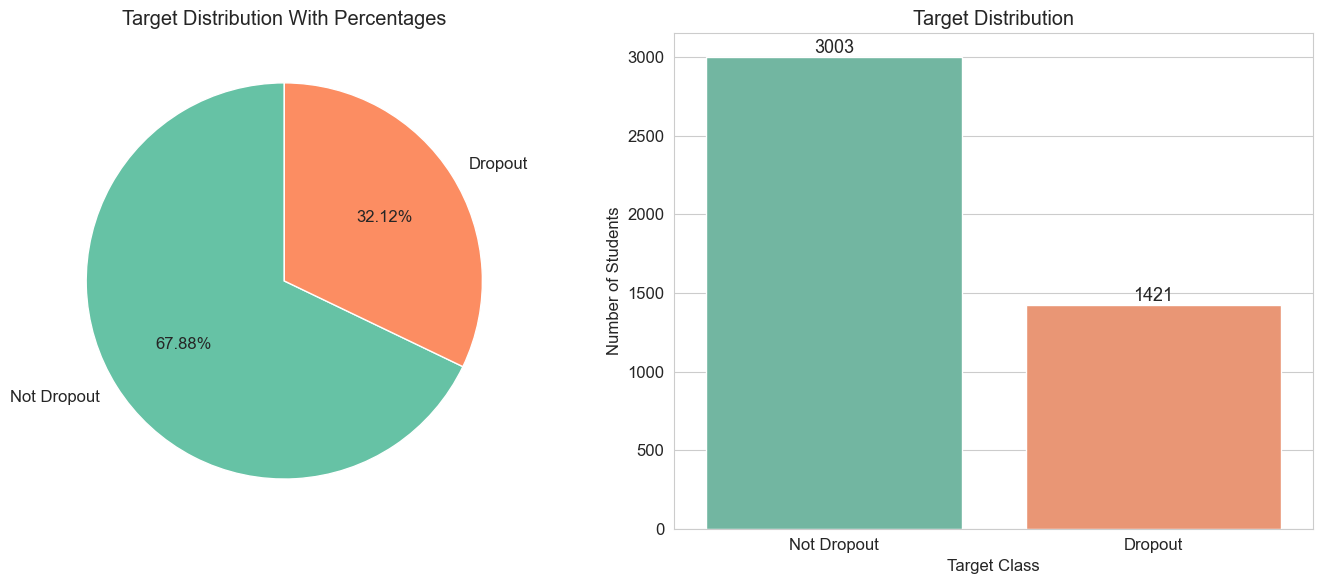

In [ ]:
# New target distribution visualization

target_counts = df['Target_Binary'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors = sns.color_palette("Set2")

# PIE CHART
ax1.pie(
    target_counts.values,
    labels=target_counts.index,
    autopct="%.2f%%",
    startangle=90,
    colors=colors
)
ax1.set_title("Target Distribution With Percentages")

# BAR CHART
palette_used = colors[:len(target_counts)]

sns.barplot(
    x=target_counts.index,
    y=target_counts.values,
    hue=target_counts.index,  
    palette=palette_used, 
    dodge=False,               
    ax=ax2,
    legend=False            
)


ax2.set_title("Target Distribution")
ax2.set_xlabel("Target Class")
ax2.set_ylabel("Number of Students")

for i, value in enumerate(target_counts.values):
    ax2.text(i, value, value, ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()


In [ ]:
print(">>> Baseline Model (Dummy) is training...")

# Strategy 'stratified': randomly assigns labels according to the class distribution in the training set.
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train_scaled, y_train)
dummy_pred = dummy_clf.predict(X_test_scaled)

print(f"Baseline Accuracy: %{accuracy_score(y_test, dummy_pred)*100:.2f}")


In [ ]:
print(">>> Initiating Hyperparameter Tuning for the Random Forest model using GridSearchCV...")

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Search space of parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# 3-Fold Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_
print(f"\n>>> Best Parameters: {grid_search.best_params_}")

In [ ]:
print(">>> Voting Classifier (RF + HGB + GB) ...")

# GradientBoosting
hgb_clf = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=200, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Voting: Tuned Random Forest + HGB + GB
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('hgb', hgb_clf), ('gb', gb_clf)],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train)
print(">>> Voting Classifier training completed.")

In [ ]:
print(">>> Evaluation is being performed on the test set...")

test_pred = voting_clf.predict(X_test_scaled)
test_probs = voting_clf.predict_proba(X_test_scaled)[:, 1]
# Metrics
print(f"\n$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
print(f" TEST ACCURACY: %{accuracy_score(y_test, test_pred)*100:.2f}")
print(f" TEST F1-SCORE: %{f1_score(y_test, test_pred, average='weighted')*100:.2f}")
print(f"\n$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
print(classification_report(y_test, test_pred, target_names=le.classes_))

# Picture1: Confusion Matrix 
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Durum')
plt.xlabel('Tahmin Edilen Durum')

# Picture2: ROC Curve 
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Picture3: Feature Importance
plt.figure(figsize=(10, 6))
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='#2ecc71')
plt.title('Feature Importance (Tuned Random Forest)')
plt.xlabel('Önem Derecesi')
plt.show()

In [ ]:
feature_importances = best_rf.feature_importances_
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=X.columns)
plt.title("Feature Importance")
plt.show()